In [1]:
import torch
from PIL import Image


/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
frame_files = os.listdir("data/extracted-train-frames/content/work/frames/train/")

In [3]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split


labels = pd.read_csv("data/train_labels.csv")
labels["frame"] =labels["step"]/10*59.95+5*59.95  
labels["frame"] = labels["frame"].astype(int) 

player_tracking =pd.read_csv("data/train_player_tracking.csv")
player_tracking["frame"] =player_tracking["step"]/10*59.95+5*59.95  
player_tracking["frame"] = player_tracking["frame"].astype(int) 


In [4]:
endzone_frame_files = pd.DataFrame({"endzone_img":[file for file in frame_files if "Endzone" in file]})
sideline_frame_files = pd.DataFrame({"sideline_img":[file for file in frame_files if "Sideline" in file]})


In [5]:
labels["endzone_img"] = labels.apply(lambda row: row['game_play']+"_"  +"Endzone.mp4_{:04d}.jpg".format(row['frame']),axis=1)
labels["sideline_img"] = labels.apply(lambda row: row['game_play']+"_"  +"Sideline.mp4_{:04d}.jpg".format(row['frame']),axis=1)

In [6]:
len(labels)

4721618

In [7]:
labels = labels.merge(endzone_frame_files).merge(sideline_frame_files)
len(labels)

4697605

### Split Test and Train data

In [8]:


train_labels, test_labels = train_test_split(labels,test_size=0.2,stratify=labels["contact"])
helmets = pd.read_csv("data/train_baseline_helmets.csv")


In [9]:
player_tracking[['x_position', 'y_position', 'speed', 'direction', 'orientation', 'acceleration', 'sa']]

,x_position,y_position,speed,direction,orientation,acceleration,sa
0,61.59,42.60,1.11,320.33,263.93,0.71,-0.64
1,59.48,26.81,0.23,346.84,247.16,1.29,0.90
2,72.19,31.46,0.61,11.77,247.69,0.63,-0.33
3,57.37,22.12,0.37,127.85,63.63,0.69,0.62
4,63.25,27.50,0.51,183.62,253.71,0.31,0.31
...,...,...,...,...,...,...,...
1353048,72.28,51.80,1.59,345.36,342.68,0.49,-0.41
1353049,74.76,54.50,0.98,342.39,354.46,0.63,-0.24
1353050,74.54,55.75,1.12,352.79,349.20,0.63,0.46
1353051,80.44,48.77,1.93,340.78,346.51,0.53,-0.51


In [10]:
helmets.head()

,game_play,game_key,play_id,view,video,frame,nfl_player_id,player_label,left,width,top,height
0,58168_003392,58168,3392,Endzone,58168_003392_Endzone.mp4,290,39947,H72,946,25,293,34
1,58168_003392,58168,3392,Endzone,58168_003392_Endzone.mp4,290,37211,H42,151,25,267,33
2,58168_003392,58168,3392,Endzone,58168_003392_Endzone.mp4,290,38590,H70,810,25,293,35
3,58168_003392,58168,3392,Endzone,58168_003392_Endzone.mp4,290,44822,H15,681,26,254,33
4,58168_003392,58168,3392,Endzone,58168_003392_Endzone.mp4,290,41944,V92,680,23,303,33


In [11]:
helmets.head()

,game_play,game_key,play_id,view,video,frame,nfl_player_id,player_label,left,width,top,height
0,58168_003392,58168,3392,Endzone,58168_003392_Endzone.mp4,290,39947,H72,946,25,293,34
1,58168_003392,58168,3392,Endzone,58168_003392_Endzone.mp4,290,37211,H42,151,25,267,33
2,58168_003392,58168,3392,Endzone,58168_003392_Endzone.mp4,290,38590,H70,810,25,293,35
3,58168_003392,58168,3392,Endzone,58168_003392_Endzone.mp4,290,44822,H15,681,26,254,33
4,58168_003392,58168,3392,Endzone,58168_003392_Endzone.mp4,290,41944,V92,680,23,303,33


player1_id 38577 player2_id 43971
frame  401
58548_003091_Endzone.mp4_0401.jpg


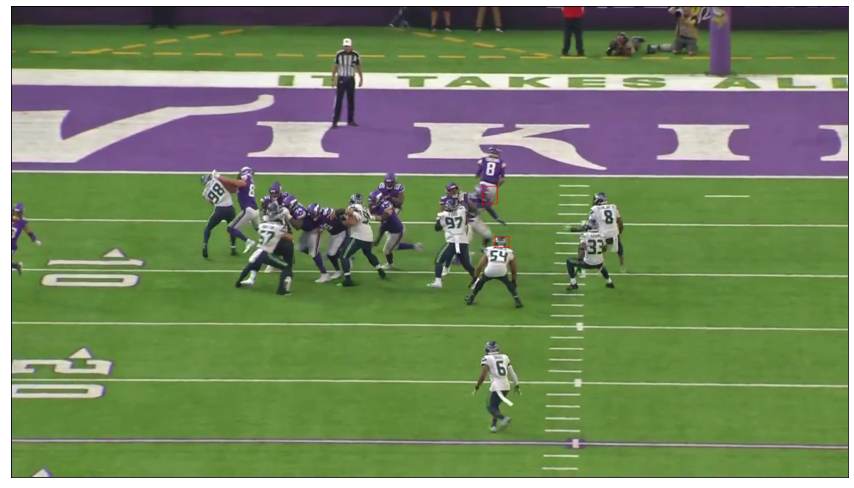

In [12]:
import random
import torch
from torchvision.utils import draw_bounding_boxes
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import numpy as np
from torchvision.io import read_image
view = "Endzone"
idx = random.randint(0, train_labels.shape[0])
idx=0
label_record = train_labels.iloc[idx]

# positive_labels = train_labels[train_labels['contact']==1]

# idx = random.randint(0, positive_labels.shape[0])
# label_record = positive_labels.iloc[idx]

player1_id = int(label_record["nfl_player_id_1"])
player2_id = label_record["nfl_player_id_2"]
if player2_id != "G":
    player2_id= int(player2_id)
print("player1_id", player1_id, "player2_id", player2_id)
game_play = label_record['game_play']
frame = int(label_record['frame'])
print("frame ", frame)

player1_record = helmets[(helmets['game_play']==game_play)&
(helmets['nfl_player_id']==player1_id)&(helmets['frame']==frame)].iloc[0]
# print(player1_record)
ymin1 = player1_record["top"]
xmin1 = player1_record["left"]
height1 = player1_record["height"]
width1 = player1_record["width"]

xmax1 = xmin1+width1
ymax1 = ymin1+height1
if player2_id != "G":
    player2_record = helmets[(helmets['game_play']==game_play)&
    (helmets['nfl_player_id']==player2_id)&(helmets['frame']==frame)].iloc[0]
    # print(player2_record)
    ymin2 = player2_record["top"]
    xmin2 = player2_record["left"]
    height2 = player2_record["height"]
    width2 = player2_record["width"]

    xmax2 = xmin2+width2
    ymax2 = ymin2+height2
else:
    xmin2,ymin2,xmax2,ymax2 = 0,0,0,0


file_name = game_play+"_" + view +".mp4_{:04d}.jpg".format(frame)
print(file_name)
# file_name ="58579_003527_Sideline.mp4_0775.jpg"
# file_name ="58168_003392_Endzone.mp4_0329.jpg"
image = read_image("data/extracted-train-frames/content/work/frames/train/"+file_name)
boxes = torch.tensor([[xmin1,ymin1,xmax1,ymax1],[xmin2,ymin2,xmax2,ymax2]])



def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False,figsize=(15, 15))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

drawn_boxes = draw_bounding_boxes(image, boxes, colors="red")
show(drawn_boxes)


### Define Dataset class

In [13]:
import torch.nn as nn
import numpy as np
from torchvision.io import read_image



class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x
class NFLDataset(torch.utils.data.Dataset):
    def __init__(self,labels, helmets, tracking,transforms):
        self.labels = labels
        self.helmets = helmets
        self.tracking = tracking


        self.transforms = transforms

    def __getitem__(self, idx):
        views = ['Endzone', 'Sideline']
        label_record = self.labels.iloc[idx]
        label = label_record['contact'].astype(np.float32)
        game_play = label_record['game_play']
        frame = int(label_record['frame'])
        # boxes =[]
        features =[]
        for player in [1,2]:

            player_id = label_record[f"nfl_player_id_{player}"]
            if player_id!="G":
                player_id = int(player_id)


                player_helmet_record = self.helmets[(self.helmets['game_play']==game_play)&
                (self.helmets['nfl_player_id']==player_id)&(self.helmets['frame']==frame)]
                player_tracking_record = self.tracking[(self.tracking['game_play']==game_play)&
                (self.tracking['nfl_player_id']==player_id)&(self.tracking['frame']==frame)]
                if len(player_tracking_record)>0:
                    player_tracking_record = player_tracking_record[['x_position', 'y_position', 'speed', 'direction', 'orientation', 'acceleration', 'sa']].values[0]
                else:
                    player_tracking_record = np.array([0,0,0,0,0,0,0])
                if len(player_helmet_record)>0:
                    player_helmet_record= player_helmet_record[["top", "left", "height", "width"]].values[0]
                else:
                    player_helmet_record = np.array([0,0,0,0])
                feature = np.concatenate([player_tracking_record, player_helmet_record])

                features.append(torch.FloatTensor(feature))
            else:
                features.append(torch.FloatTensor([0,0,0,0,0,0,0,0,0,0,0]))

        
        for view in views:
            file_name = game_play+"_" + view +".mp4_{:04d}.jpg".format(frame)
            image = read_image("data/extracted-train-frames/content/work/frames/train/"+file_name)
            if view == "Endzone":
                endzone_img = image.float()
            else:
                sideline_img = image.float()
        # image = torch.stack([image.float(),image.float(),image.float()])
        # image_ft = self.ft_extractor(image)
        features = torch.concat(features)
        return endzone_img,sideline_img ,features, torch.tensor(label)

    def __len__(self):
        return len(self.labels)



In [14]:
from torch.utils.data import DataLoader
batch_size = 64

train_ds = NFLDataset(train_labels,helmets, player_tracking, None)
train_loader = DataLoader(train_ds,batch_size=batch_size, shuffle=True)
test_ds = NFLDataset(test_labels,helmets, player_tracking, None)
test_loader = DataLoader(test_ds,batch_size=batch_size, shuffle=True)
#
endzone_imges, sideline_imges, ft_batch, labels = next(iter(train_loader))

### Define Network

In [15]:
import torch.nn as nn
import torchvision
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.ft_extractor = torchvision.models.resnet18(pretrained=True)
        for param in self.ft_extractor.parameters():
            param.requires_grad = False
        num_ftrs = self.ft_extractor.fc.in_features
        self.ft_extractor.fc = Identity()
        self.mlp = nn.Sequential(
            nn.Linear(22, 64),
            nn.LayerNorm(64),
            nn.ReLU(),
            nn.Dropout(0.2),

        )
        self.fc = nn.Linear(64+512*2, 1)

    def forward(self, endzone_img, sideline_img, feature):
        # b, c, h, w = img.shape
        # img = img.reshape(b*2, c//2, h, w)
        # img = self.backbone(img).reshape(b, -1)
        endzone_img = self.ft_extractor(endzone_img)
        sideline_img = self.ft_extractor(sideline_img)

        feature = self.mlp(feature)
        y = self.fc(torch.cat([endzone_img,sideline_img, feature], dim=1))
        return y


In [16]:
model= Model()
output = model(endzone_imges, sideline_imges, ft_batch)

/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Define Training Procedure

In [17]:
from sklearn.metrics import recall_score, f1_score, accuracy_score
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (endzone_imges, sideline_imges, ft_batch, labels) in enumerate(dataloader):
        # Compute prediction and loss
        endzone_imges, sideline_imges, ft_batch, labels =endzone_imges.to(device), sideline_imges.to(device), ft_batch.to(device), labels.to(device) 
        pred = model(endzone_imges, sideline_imges, ft_batch)
        loss = loss_fn(pred.squeeze(), labels)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(endzone_imges)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss=0
    y_true = []
    y_preds = []

    with torch.no_grad():
        for batch, (endzone_imges, sideline_imges, ft_batch, labels) in enumerate(dataloader):
        # Compute prediction and loss
            endzone_imges, sideline_imges, ft_batch, labels =endzone_imges.to(device), sideline_imges.to(device), ft_batch.to(device), labels.to(device) 
            pred = model(endzone_imges, sideline_imges, ft_batch)
            test_loss += loss_fn(pred.squeeze(), labels).item()
            y_preds(torch.round(torch.sigmoid(pred).squeeze()).numpy())
            y_true += list(labels.numpy())

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [18]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")
model = Model().to(device)
print(model)


Using cuda device
Model(
  (ft_extractor): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, a

In [19]:
learning_rate = 1e-3
epochs = 1

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer)
    test_loop(test_loader, model, loss_fn)
print("Done!")


Epoch 1
-------------------------------
loss: 0.992472  [    0/3758084]
loss: 0.019834  [ 6400/3758084]


In [ ]:
print("hello")